# Tutorial 9.2: Change-Point Detection for a Poisson Process
### Neuroscience goal:
- learn how to extract state changes from noisy spike trains
- learn limitations of the process
### Computational goal:
- calculate log-likelihood ratios to combine probabilities
- produce scatter plots and a correlation coefficient
### Overview
- will produce poisson process for a single neuron, whose rate changes at a randomly determined time point within a trial
- will produce multiple trials, assess how well a change point detection algorithm extracts the correct change point

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [209]:
dt = 1e-3
tmax = 10
t = np.arange(0, tmax, dt)

### 1. define change points
- set of 50 different change points, each randomly chosen in interval from (0, 10)s

In [2]:
change_points = np.random.uniform(0, 10, 50)

### 2. produce spike trains
- fifty spike trains, one for each value of the change point
- Poisson emission of spikes at rate $r_{i} = 5$ Hz before change-point, and rate $r_{2} = 10$ Hz after the change-point

In [230]:
spike_trains = np.full((50, len(t)), 5)
original_rates = np.full((50, len(t)), 5)

for i, change_point in enumerate(change_points):
    idx = int(change_point/dt)
    spikes_before = np.random.poisson(5 * dt, idx)
    spikes_before[spikes_before > 1] = 1
    
    spikes_after = np.random.poisson(10 * dt, len(t) - idx)
    spikes_after[spikes_after > 1] = 1 
    
    spike_trains[i, :idx] = spikes_before
    spike_trains[i, idx:] = spikes_after

    original_rates[i, idx:] = 10

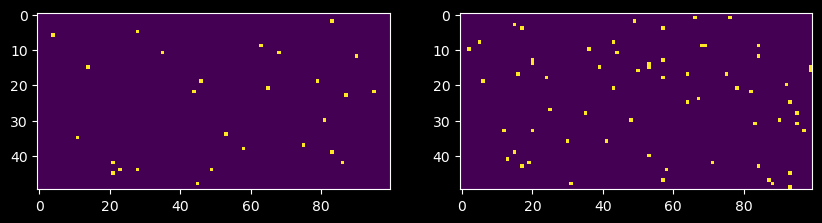

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(spike_trains[:, :100])
ax[1].imshow(spike_trains[:, -100:])

### 3. plot likelihood ratio
- for first spike train, plot as a function of $T_1$, which can vary in 1ms increments, the log likelihood ratio indicating the probability of the spike train being produced by an inhomogenous Poisson process with a rate jump at $T_1$ divided by the probability of it being produced by a single homogenous Poisson process:

$$
P(T_1) = [\frac{N_1}{T_1}]^{N_1} [\frac{N_2}{T_2}]^{N_2} \space/ \space[\frac{N}{T}]^{N}
$$

which yields:
$$
\ln[P(T_1)] = N_1 \ln[\frac{N_1}{T_1}] + N_2 \ln[\frac{N_2}{T_2}] - N \ln[\frac{N}{T}]
$$

where T = 10s, $T_2 = T - T_1$, N is the total number of spikes in time T, $N_1$ is the number of spikes before $T_2$, and $N_2 = N - N_1$ is the remaining number of spikes after $T_1$ (in the subinterval of length $T_2$)

Text(0.5, 1.0, 'log likelihood ratio as function of $T_1$')

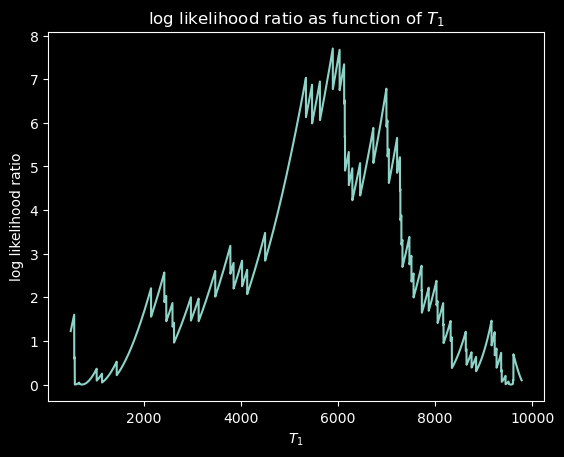

In [149]:
train = spike_trains[0]
def log_likelihood_ratio(spike_train, t1):
    n = np.sum(spike_train)
    n1 = np.sum(spike_train[:t1])
    n2 = n - n1
    t2 = len(t) - t1
    # divide by 0
    if n1 == 0 or n2 == 0:
        return-np.inf

    return n1 * np.log(n1/t1) + n2 * np.log(n2/t2) - n * np.log(n/len(t))

# t1 values
t1_vals = np.arange(1, len(t))
log_likelihood_ratios = np.asarray([log_likelihood_ratio(train, t1) for t1 in t1_vals])
# plot
plt.plot(log_likelihood_ratios)
plt.xlabel('$T_1$')
plt.ylabel('log likelihood ratio')
plt.title('log likelihood ratio as function of $T_1$')

### 4. estimate change-point as value of $T_1$ with maximum log-likelihood ratio

In [150]:
max_ratio_index = np.argmax(log_likelihood_ratios)
t1 = max_ratio_index
t2 = len(t) - t1

### 5. plot estimated firing rate as function of time
- assuming estimated rates of $N_1 / T_1$ and $N_2 / T_2$ respectively before and after the estimated change-point
- on the same graph, plot the firing rate used to generate the spike train

In [184]:
rate_1 = np.sum(train[:t1]) / t1
rate_2 = np.sum(train[t1:]) / t2

est_rate = np.zeros(len(t))
est_rate[:t1] = rate_1*1000
est_rate[t1:] = rate_2*1000

change_0 = int(change_points[0] / dt)
original_rate = np.full(len(t), 5)
original_rate[change_0:] = 10
n_t = np.full(len(t), (np.sum(train)/len(t))/dt)

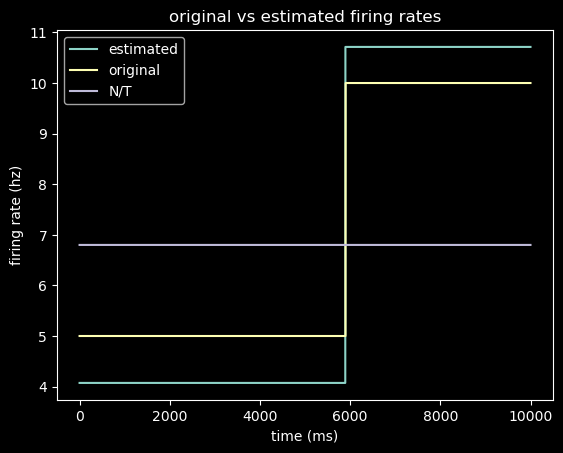

In [187]:
plt.plot(est_rate, label='estimated')
plt.plot(original_rate, label='original')
plt.plot(n_t, label='N/T')
plt.xlabel('time (ms)')
plt.ylabel('firing rate (hz)')
plt.title('original vs estimated firing rates')
plt.legend()

### 6
- calculate square root of mean-squared error in estimate of firing rate, and square root of mean-squared error if the firing rate were assumed to be fixed at N/T for the entire trial
- plot values on scatter 

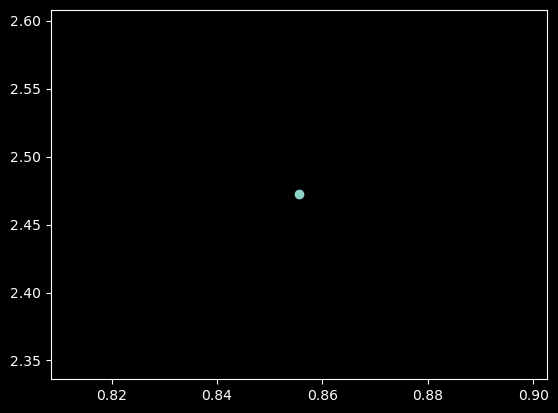

In [190]:
est_rmse = np.sqrt(np.mean((original_rate - est_rate) ** 2))
n_t_rmse = np.sqrt(np.mean((original_rate - n_t) ** 2))
plt.scatter(est_rmse, n_t_rmse)

### 7. repeat for all trials 

In [264]:
all_trial_ratios = np.asarray([[log_likelihood_ratio(spike_trains[i], t1) for t1 in t1_vals] for i in range(50)])
max_indices = np.argmax(all_trial_ratios, axis=1)
t2 = len(t) - max_indices

n_ts = ((np.sum(spike_trains, axis=1)/len(t))/dt)
n_ts = np.tile(n_ts[:, np.newaxis], (1, len(t)))


est_rmses = []
n_t_rmses = []


for i, train in enumerate(spike_trains):
    t1_val = max_indices[i]
    t2_val = t2[i]

    rate_1 = np.sum(train[:t1]) / t1_val
    rate_2 = np.sum(train[t1:]) / t2_val

    est_rate = np.zeros(len(t))
    est_rate[:t1_val] = rate_1 / dt
    est_rate[t1_val:] - rate_2 / dt

    est_rmse = np.sqrt(np.mean((original_rates[i] - est_rate) ** 2))
    n_t_rmse = np.sqrt(np.mean((original_rates[i] - n_t[i]) ** 2))

    est_rmses.append(est_rmse)
    n_t_rmses.append(n_t_rmse)

est_rmses = np.array(est_rmses)
n_t_rmses = np.array(n_t_rmses)


Text(0, 0.5, 'n/t')

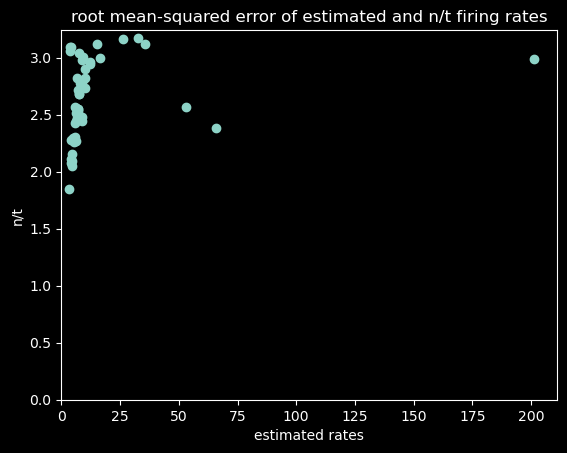

In [266]:
plt.scatter(est_rmses, n_t_rmses)
plt.title('root mean-squared error of estimated and n/t firing rates')
plt.xlabel('estimated rates')
plt.xlim(0)
plt.ylim(0)
plt.ylabel('n/t')

### 8
- calculate the correlation between the estimated chnage point and the change point used to generate each spike train
- plot on scatter plot

In [282]:
est_change_points = np.argmax(all_trial_ratios, axis=1) * dt

In [284]:
coeff = np.polyfit(change_points, est_change_points, 1)
line = np.poly1d(coeff)
x_line = np.linspace(min(change_points), max(change_points), 1000)

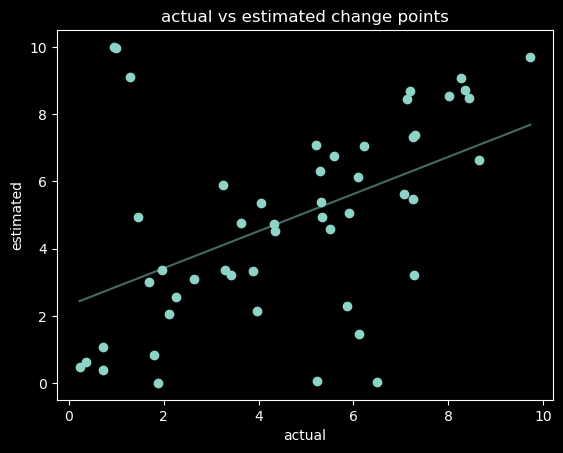

In [291]:
plt.scatter(change_points, est_change_points)
plt.plot(x_line, line(x_line), alpha=0.5)
plt.xlabel('actual')
plt.ylabel('estimated')
plt.title('actual vs estimated change points')
plt.show()